# SeHo Capital Management

### Code inspiration from: [towardsdatascience](https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f)

In [82]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

import time
import datetime
import os
import pickle
import myFunctions

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Getting data:

In [83]:
# Start and end date:
start =  int(time.mktime(datetime.date(2000,1,1).timetuple()))
end =  int(time.mktime(datetime.date(2020,6,30).timetuple()))

# List of assets:
links =[]
ticker_list = []

# Europe: iShares Europe ETF (IEV)
ticker_list.append('IEV')
# US: iShares Core S&P 500 ETF (IVV)
ticker_list.append('IVV')
# Emerging: iShares Core MSCI Emerging Markets ETF (IEMG)
ticker_list.append('IEMG')
# Japan: iShares MSCI Japan UCITS ETF USD (Dist) (IJPN.AS)
ticker_list.append('IJPN.AS')
# China: iShares MSCI China ETF (MCHI)
ticker_list.append('MCHI')
# Gold: Aberdeen Standard Gold ETF Trust (SGOL)
ticker_list.append('SGOL')
# Oil: United States Oil Fund, LP (USO)
ticker_list.append('USO')
# Agriculture:  Invesco DB Agriculture Fund (DBA)
ticker_list.append('DBA')
# Bonds: iShares Core U.S. Aggregate Bond ETF (AGG)
ticker_list.append('AGG')

for ticker in ticker_list:
    links.append(myFunctions.yahooLink(start, end, ticker))


num_assets = len(links)

In [85]:
# Pulling data or loading if already pulled:
df_full = pd.DataFrame()

if os.path.isfile('./data/stockData.pkl'):
    df_full = pd.read_pickle("./data/stockData.pkl")
else:
    for idx, link in enumerate(links):
        print(idx, link)
        df_temp = pd.read_csv(link)
        df_temp['ticker'] = ticker_list[idx]
        df_full = df_full.append(df_temp) 
    df_full.to_pickle("./data/stockData.pkl")

In [86]:
# Taking a subsample
data = pd.DataFrame()
data['date'] = df_full['Date']
data['ticker'] = df_full['ticker']
data['adj_close'] = df_full['Adj Close']
#data.head()

In [94]:
# Displaying data
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns =  ['Bonds', 'Agriculture', 'Emerging', 'Europe', 'Japan', 'US', 'China', 'Gold', 'Oil'] #table.columns = [col[1] for col in table.columns]
table = table.dropna()
table.head()

,Bonds,Agriculture,Emerging,Europe,Japan,US,China,Gold,Oil
date,,,,,,,,,
2012-10-24,91.937454,28.297958,40.168869,29.454409,7.050,120.700333,38.542637,16.799000,253.039993
2012-10-25,91.740372,28.190807,40.435436,29.638401,7.095,121.066887,38.767368,16.916000,254.240005
2012-10-26,91.986710,28.064173,40.143871,29.630398,7.030,120.990158,38.309246,16.910999,254.320007
2012-10-31,92.118103,28.181067,40.177193,29.702398,7.005,120.606522,38.343822,17.004000,254.240005
2012-11-01,91.997131,28.229773,40.818634,30.046370,7.055,122.294464,39.484806,16.927999,256.480011


## Data Description

In [98]:
returns = np.log(table) - np.log(table.shift(1))

Text(0, 0.5, 'Normalized prices')

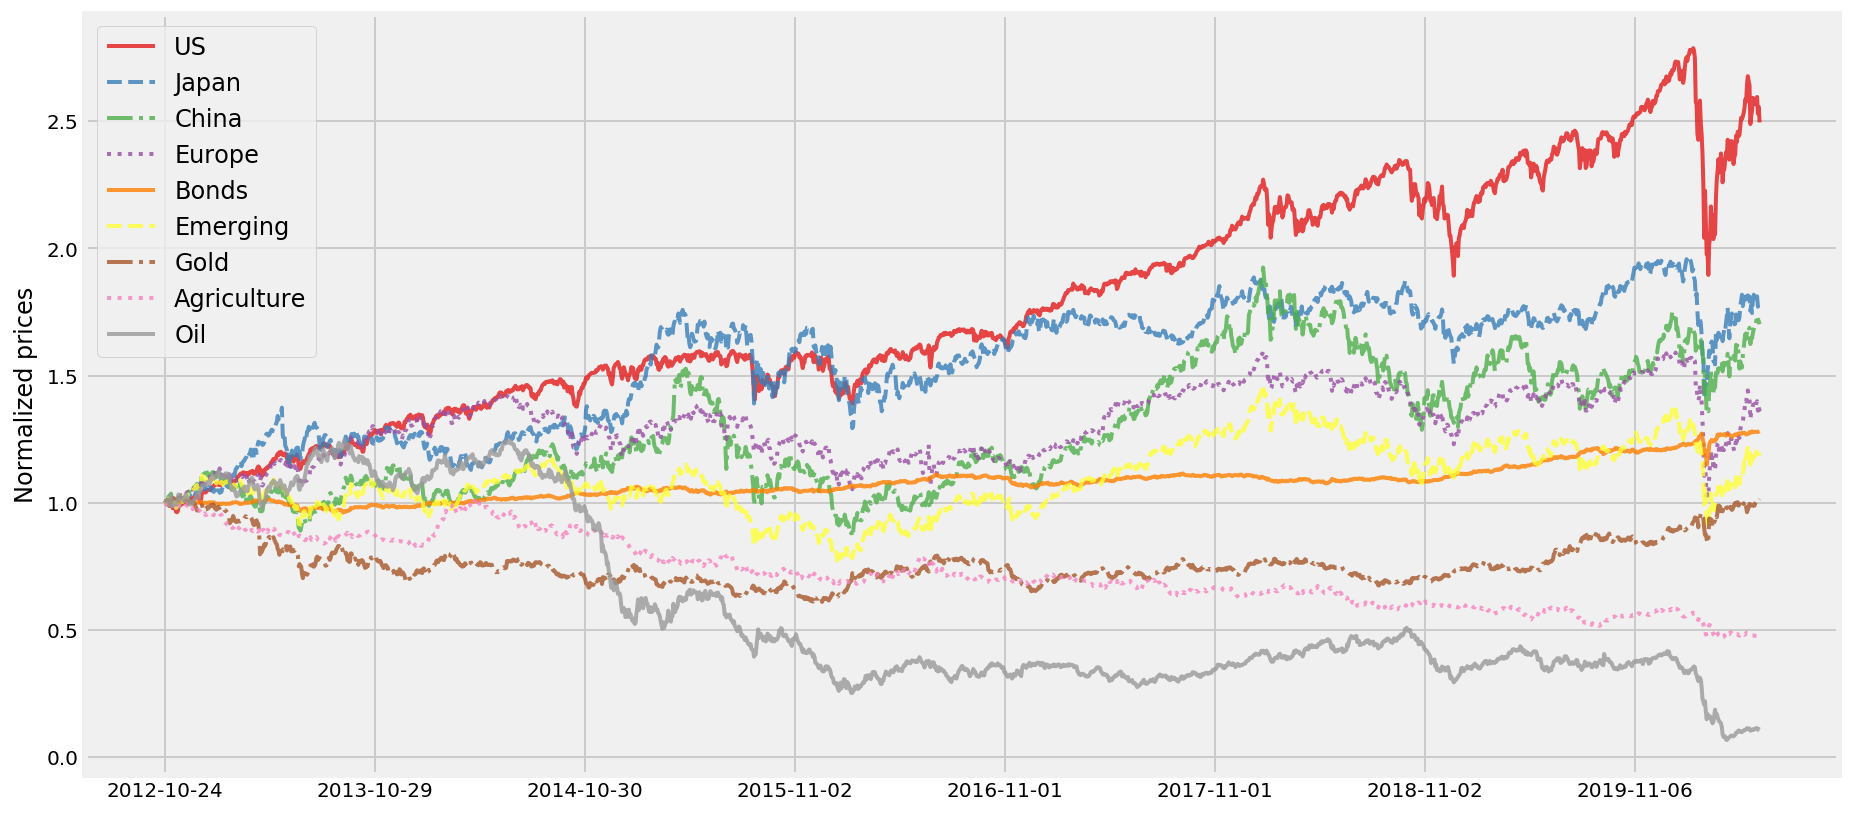

In [99]:
table_norm = table / table.iloc[0,:] # Normalize values to start at 1
ax = plt.gca()
palette = plt.get_cmap('Set1')

styles = ['-', '--', '-.', ':']

for idx, series in enumerate(returns.mean().sort_values(ascending = False).index):
    table_norm[series].plot(figsize=(14, 7), lw=2, alpha=0.8, color=palette(idx), style = styles[idx % 4], ax=ax)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("")
plt.ylabel('Normalized prices')

In [100]:
#returns = table.pct_change()
returns = np.log(table) - np.log(table.shift(1))
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.02

In [107]:
print("-"*80)
print("Historical data return\n")
print(round(mean_returns*252*100,2))
print("-"*80)

print("Adjusted expected return according to Schwab return\n")
mean_returns['Gold'] = 0.02/252 # Grow with inflation
mean_returns['Oil'] = 0.02/252 # Grow with inflation
mean_returns['US'] = 0.074/252 # https://www.schwab.com/resource-center/insights/content/why-market-returns-may-be-lower-in-the-future
mean_returns['Europe'] = 0.077/252 # https://www.schwab.com/resource-center/insights/content/why-market-returns-may-be-lower-in-the-future
mean_returns['Emerging'] = 0.08/252 #  Schwab + a bit
mean_returns['China'] = 0.09/252 
mean_returns['Bonds'] = 0.019/252 # https://www.schwab.com/resource-center/insights/content/why-market-returns-may-be-lower-in-the-future

print(round(mean_returns*252*100,2))

print("-"*80)


--------------------------------------------------------------------------------
Historical data return

Bonds           1.90
Agriculture   -10.17
Emerging        8.00
Europe          7.70
Japan           7.69
US              7.40
China           8.00
Gold            2.00
Oil             2.00
dtype: float64
--------------------------------------------------------------------------------
Adjusted expected return according to Schwab return

Bonds           1.90
Agriculture   -10.17
Emerging        8.00
Europe          7.70
Japan           7.69
US              7.40
China           9.00
Gold            2.00
Oil             2.00
dtype: float64
--------------------------------------------------------------------------------


## Optimal Portfolio Allocations

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.15


            Bonds  Agriculture  Emerging  Europe  Japan     US  China  Gold  \
allocation    0.0          0.0       0.0   12.87  32.73  33.55  16.41  4.44   

            Oil  
allocation  0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.01
Annualised Volatility: 0.04


            Bonds  Agriculture  Emerging  Europe  Japan    US  China  Gold  \
allocation   88.0         8.53       0.0     0.0   2.83  0.63    0.0   0.0   

            Oil  
allocation  0.0  
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

Bonds : annuaised return 0.02 , annualised volatility: 0.04
Agriculture : annuaised return -0.1 , annualised volatility: 0.12
Emerging :

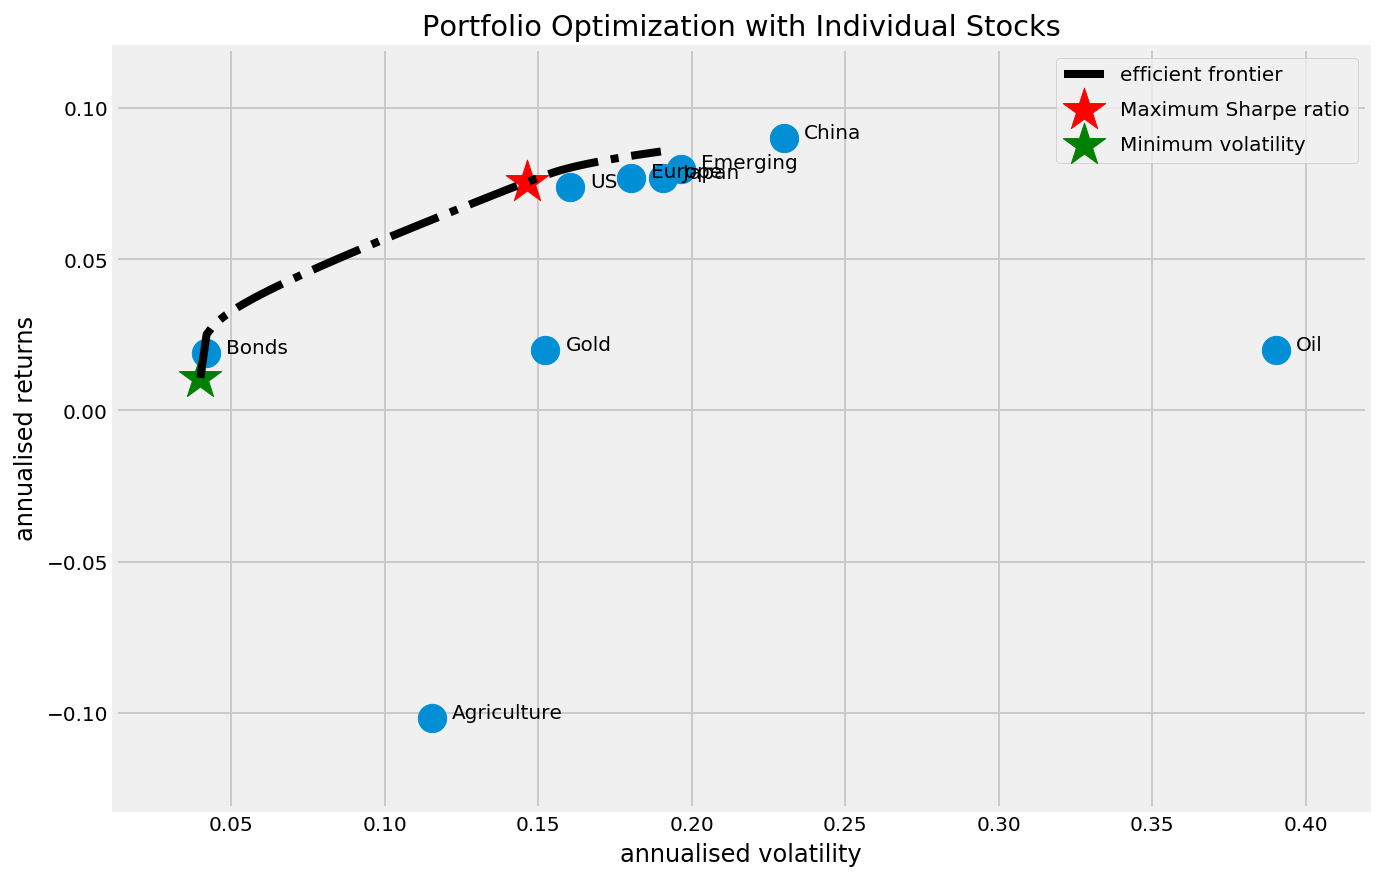

In [108]:
myFunctions.display_ef_with_selected(table, mean_returns, cov_matrix, risk_free_rate)